# Problem 3 (100 points)

In this problem, you are asked to study Contrastive Language-Image Pre-Training (CLIP), a powerful tool in multimodal AI.

In [1]:
# Run code in this cell

"""
DO NOT MAKE ANY CHANGE IN THIS CELL.

HINT: If something is not corrected installed, simply run this cell for few more times.
"""

!pip install datasets transformers

> WARNING !!!
> 
- Beyond importing libraries/modules/classes/functions in the preceding cell, you are **NOT allowed to import anything else for the following purposes**:
    - **As a part of your final solution.** For instance, if a problem asks you to build a model without using sklearn but you use it, then you will not earn points.
    - **Temporarily import something to assist you to get a solution.** For instance, if a problem asks you to manually compute eigenvalues but you temporarily use `np.linalg.eig` to get an answer and then delete your code, then you violate the rule.

    **Rule of thumb:** Each part has its particular purpose to intentionally test you something. Do not attempt to find a shortcut to circumvent the rule.

In [2]:
# Run code in this cell

"""
DO NOT MAKE ANY CHANGE IN THIS CELL.
"""

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, ViTModel

**We will use flickr30k dataset to do image-language matching.**

In [3]:
# Run code in this cell

"""
DO NOT MAKE ANY CHANGE IN THIS CELL.
"""

from datasets import load_dataset

dataset_train = load_dataset("USAAIO/2025-Round2-Problem3", split='train')

## Part 1 (5 points, coding task)

Do the following tasks to explore the properties of `dataset_train`:

1. `dataset_train` is a list-like object. Print the number of elements in it.
2. Consider index `idx = 2025`. Print the type of `dataset_train[idx]`.
3. Print all keys in `dataset_train[idx]`.
4. Name the value associated with the key `image` as `image_PIL`. Print it.
5. Convert `image_PIL` to a NumPy array object, called `image_np`. Print `image_np` and its shape.
6. Display this image by using `plt.imshow`.
7. Print the value associated with the key `alt_text`. Print its type.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [4]:
len(dataset_train)

29000

In [5]:
type(dataset_train[2025])

dict

In [6]:
dataset_train[2025].keys()

dict_keys(['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'])

In [7]:
image_PIL = dataset_train[2025]["image"]
repr(image_PIL)

'<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x26DE27161E0>'

In [8]:
image_np = np.array(image_PIL)
image_np, image_np.shape

(array([[[ 35,  19,   3],
         [ 45,  24,   3],
         [ 37,  23,  12],
         ...,
         [ 16,  12,   3],
         [  7,   4,   0],
         [  1,   2,   0]],
 
        [[ 36,  24,  12],
         [ 45,  23,   0],
         [ 33,  15,   5],
         ...,
         [ 19,  14,   8],
         [ 11,   8,   1],
         [  8,   5,   0]],
 
        [[ 27,   9,   0],
         [ 21,  11,   0],
         [ 15,   5,   0],
         ...,
         [ 14,  11,   4],
         [ 13,   8,   2],
         [ 13,   8,   2]],
 
        ...,
 
        [[126, 114,  90],
         [198, 179, 110],
         [ 50,  25,   0],
         ...,
         [ 34,  37,  10],
         [ 47,  34,   2],
         [ 10,   2,   0]],
 
        [[129, 102,  59],
         [ 68,  50,  40],
         [ 33,   8,   3],
         ...,
         [ 98,  90,   7],
         [ 40,  34,  10],
         [ 11,   1,   9]],
 
        [[ 13,   3,   1],
         [ 77,  45,  32],
         [186, 140,  81],
         ...,
         [ 12,  12,   2],
  

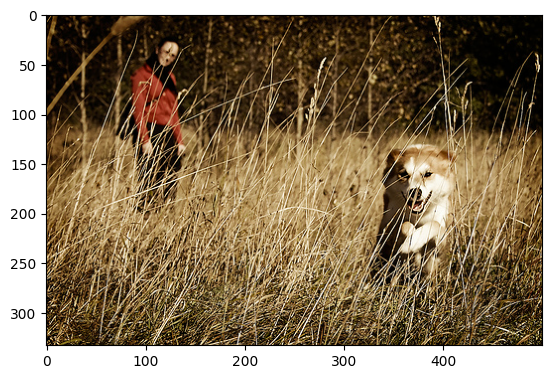

In [9]:
plt.imshow(image_PIL);

In [10]:
dataset_train[2025]["alt_text"], type(dataset_train[2025]["alt_text"])

(['A person in red stands in the background, watching a golden dog run through a field of tall grass.'],
 list)

""" END OF THIS PART """

## Part 2 (5 points, coding task)

This dataset is too big. In our contest, we only use a small portion with 1000 samples.

To avoid introducing any bias, we will randomly select 1000 distinct samples.

**Use NumPy to randomly select 1000 sample indices.**

- Use the random seed number 2025 to generated randomized indices. After the generation is completed, reset the seed number back to `None`.
- The name of the output is called `indices`. It must be a list that contains 1000 integer type (not numpy array integers) objects.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [11]:
np.random.seed(2025)
indices = np.random.permutation(len(dataset_train))[:1000].tolist()
np.random.seed(None)

""" END OF THIS PART """

## Part 3 (5 points, coding task)

**In this part, we create our image and text datasets.**

- All sample indices are selected from `indices` generated in Part 2.
- All images (resp. texts) are extracted from the key `image` (resp. `alt_text`).
- The image (resp. text) dataset is called `image_list` (resp. `text_list`). The data type of both datasets is `list`.
- In `image_list`, each element is a **PIL** object.
- In `text_list`, each element is a **string** object.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [12]:
image_list = dataset_train[indices]["image"]
text_list = list(map(lambda x: x[0], dataset_train[indices]["alt_text"]))
type(image_list[0]), type(text_list[0])

(PIL.JpegImagePlugin.JpegImageFile, str)

""" END OF THIS PART """

# Part 4 (5 points, coding task)

**In this part, we preprocess image data.**

1. Your job is to create a tensor `images_pt` from `image_list` that has shape `(1000,3,224,224)` and datatype `float64`.
   - The data range is from -1 to 1.
   - Hint: If `a` is a PIL object, then you can use `a.resize` to resize it.
2. Print `images_pt.shape`.
3. Print `images_pt.dtype`.
4. Print `images_pt[5]`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [13]:
images_pt = np.stack([np.array(image.resize((224, 224))) for image in image_list])  # Resize
images_pt = torch.tensor(images_pt, dtype=torch.float64).permute((0, 3, 1, 2))  # To tensor format
images_pt = (images_pt / 255) * 2 - 1  # Normalize to [-1, 1]
images_pt.shape, images_pt.dtype

(torch.Size([1000, 3, 224, 224]), torch.float64)

In [14]:
images_pt[5]

tensor([[[-0.9922, -0.9843, -1.0000,  ..., -0.0118, -0.1059, -0.0667],
         [-0.8431, -0.8745, -0.9451,  ...,  0.1137,  0.0118,  0.0275],
         [-0.6941, -0.8039, -0.9137,  ..., -0.0196, -0.1451, -0.1373],
         ...,
         [-0.9529, -0.9294, -0.9529,  ..., -0.9608, -0.9765, -0.9294],
         [-0.5373, -0.7255, -0.8353,  ..., -0.8588, -0.9294, -0.9059],
         [-0.5608, -0.4902, -0.5216,  ..., -0.9137, -0.8118, -0.8824]],

        [[-0.1686, -0.1529, -0.1451,  ...,  0.1451,  0.1137,  0.1451],
         [-0.0980, -0.0980, -0.0980,  ...,  0.2392,  0.1529,  0.1922],
         [-0.0510, -0.0353, -0.0275,  ...,  0.1451,  0.0667,  0.0824],
         ...,
         [-0.6157, -0.5216, -0.5294,  ..., -0.6235, -0.6706, -0.6784],
         [-0.1765, -0.2392, -0.3412,  ..., -0.6235, -0.6863, -0.6627],
         [-0.3333, -0.1765, -0.2471,  ..., -0.6549, -0.6078, -0.6392]],

        [[ 0.0745,  0.1137,  0.1451,  ...,  0.3804,  0.2863,  0.3647],
         [ 0.1451,  0.2000,  0.2000,  ...,  0

""" END OF THIS PART """

## Part 5 (5 points, non-coding task)

Note that our final goal is to build a CLIP neural network. For the image data, we will use Vision Transformers (ViT) to extract image embeddings.

**With the above high level information, please explain the reasons behind the following things that you did in Part 4.**

1. Why the channel dimension is ahead of the height and width dimensions?
2. Why the sizes of all images are normalized to `(224,224)`?
3. Why each pixel value is normalized between -1 and 1?

\#\#\# WRITE YOUR SOLUTION HERE ###

Pretrained ViT are trained with these specific input formats, and matching them ensures compatibility and optimal performance.

This answers to all three questions.

""" END OF THIS PART """

## Part 6 (5 points, coding task)

In this part, we preprocess text data `text_list`.

1. Do tokenization with
   ```python
   tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
   ```
2. Call
   ```python
   token_id_list = tokenizer(text_list)['input_ids']
   ```
3. Print `token_id_list`.
4. Print the type of `token_id_list`.
5. Print the length of `token_id_list`.
6. Print `token_id_list[5]`.
7. Print the type of `token_id_list[5]`.
8. Print the type of `token_id_list[5][0]`.
9. For each `idx`, convert `token_id_list[idx]` from the above type to a 1-dim tensor. That is, after this step, `token_id_list` is a list that consists of all 1-dim tensors.
10. Print `token_id_list[5:7]`.
11. Print the data type of `token_id_list[5][0]`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [16]:
token_id_list = tokenizer(text_list)["input_ids"]
token_id_list, type(token_id_list), len(token_id_list)

([[101,
   1037,
   2711,
   2007,
   2601,
   2606,
   1010,
   4147,
   1037,
   20345,
   1010,
   7719,
   2006,
   1996,
   3509,
   1998,
   3544,
   2000,
   2022,
   8455,
   1037,
   2718,
   2006,
   1996,
   2132,
   2011,
   1037,
   6081,
   29561,
   8691,
   1012,
   102],
  [101,
   1037,
   2711,
   7719,
   1999,
   1037,
   3242,
   2279,
   2000,
   2037,
   15620,
   2007,
   2049,
   8260,
   2341,
   2330,
   1010,
   2096,
   2178,
   2711,
   4832,
   2011,
   2019,
   2330,
   2341,
   1012,
   102],
  [101,
   1037,
   2177,
   1997,
   4268,
   2024,
   2652,
   1999,
   1037,
   2300,
   9545,
   1999,
   1037,
   2103,
   8232,
   1012,
   102],
  [101,
   1037,
   2711,
   2003,
   5559,
   1037,
   7997,
   1998,
   2667,
   2000,
   2079,
   1037,
   7577,
   1012,
   102],
  [101,
   2048,
   2111,
   2024,
   15962,
   1010,
   2028,
   4147,
   1037,
   7308,
   2007,
   1037,
   5210,
   2006,
   2009,
   1012,
   102],
  [101,
   1037,
   4845,
   

In [17]:
token_id_list[5], type(token_id_list[5])

([101,
  1037,
  4845,
  11651,
  1037,
  2630,
  4954,
  28880,
  1998,
  12271,
  1037,
  14175,
  6277,
  2058,
  1037,
  2235,
  4400,
  1999,
  4408,
  2630,
  2300,
  1012,
  102],
 list)

In [18]:
type(token_id_list[5][0])

int

In [19]:
token_id_list = list(map(lambda x: torch.tensor(x), token_id_list))
token_id_list[5:7], token_id_list[5][0].dtype

([tensor([  101,  1037,  4845, 11651,  1037,  2630,  4954, 28880,  1998, 12271,
           1037, 14175,  6277,  2058,  1037,  2235,  4400,  1999,  4408,  2630,
           2300,  1012,   102]),
  tensor([  101,  1037,  2775,  1998,  2178,  4845,  2377,  2104,  1996, 29499,
           1011, 11089,  4472,  1997,  1037,  3653,  1011,  2081,  2793,  2006,
           4653,  1999,  1037,  3573,  1012,   102])],
 torch.int64)

""" END OF THIS PART """

## Part 7 (5 points, non-coding task)

This part follows Part 6.

**Do the following tasks.**

1. Explain why token lists of all samples begin with token ID 101.
2. Explain why token lists of all samples end with token ID 102.

\#\#\# WRITE YOUR SOLUTION HERE ###

1. Token ID 101 is a `[CLS]` token. It denotes the start of a sentence.
2. Token ID 101 is a `[SEP]` token. It denotes the end of a sentence.

> Note:
>
> ```python
> tokenizer.convert_ids_to_tokens([101, 102])  # -> ['[CLS]', '[SEP]']
> ```

""" END OF THIS PART """

## Part 8 (5 points, coding task)

**In this part, we prepare our CLIP dataset.**

1. Define class `MyDataset` that subclasses `Dataset`.
   - `__init__`
      - Inputs: `images_pt`, `token_id_list`.
      - Attributes: Same as inputs.
   - `__len__`
      - Output: total number of samples.
   - `__getitem__`
      - Input: sample index `idx`.
      - Outputs: `images_pt[idx]`, `token_id_list[idx]`.
2. Define dataset `CLIP_dataset` that is an object of `MyDataset`.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [20]:
class MyDataset(Dataset):
    def __init__(self, images_pt, token_id_list):
        super().__init__()
        self.images_pt = images_pt
        self.token_id_list = token_id_list

    def __len__(self):
        return len(self.token_id_list)

    def __getitem__(self, idx):
        return images_pt[idx], token_id_list[idx]

In [21]:
CLIP_dataset = MyDataset(images_pt, token_id_list)

""" END OF THIS PART """

## Part 9 (5 points, coding task)

### Part 9.1

**Define your own collate function.**

- The function name is `my_collate_fn`.
- Padding
  - For text data, let the longest sample be with `K` tokens.
  - Consider another text sample with `L` tokens satisfying `L < K`. Then, in addition to those `L` tokens, this sample is padded with `K-L` padding tokens whose values are 0.
- Outputs
  - `image_batch`. This is a tensor that has shape `(B,3,224,224)`.
  - `token_id_batch`. If the batch size is `B` and the longest sample in the text data has `K` tokens, then `token_id_batch` is a tensor with shape `(B,K)`.
  - `attention_mask_batch`. This is a tensor that has shape `(B,K)`. If a position is occupied by a non-padding token, its value is 1. Otherwise, if it is occupied by a padding token, its value is 0. Data types are `int64`.

### Part 9.2

**Define a DataLoader object called `CLIP_dataloader`.**

- Set `batch_size = 16`.
- Set `shuffle = True`.
- Use the collate function defined in Part 9.1.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [22]:
def my_collate_fn(batch):
    images, token_ids = zip(*batch)
    image_batch = torch.stack(images)

    K = max(map(len, token_ids))
    token_id_batch = torch.tensor(
        np.stack(
            [np.pad(item, (0, K - len(item))) for item in token_ids]  # Pad left = 0, pad right = K-L
        )
    )
    attention_mask_batch = (token_id_batch != 0).to(torch.int64)
    return image_batch, token_id_batch, attention_mask_batch

---

In [23]:
CLIP_dataloader = DataLoader(CLIP_dataset, batch_size=16, shuffle=True, collate_fn=my_collate_fn)

""" END OF THIS PART """

## Part 10 (5 points, non-coding task)

**In this part, you are asked to answer some questions about a CLIP model that you shall build in the next part.**

- Write your answers in the text cell below.
- To get answers, you may need to run experimental code to better learn the ViT and BERT models.
- We only grade your answers in the text cell.

1. **Image encoder**
   - Define `model_image = ViTModel.from_pretrained('google/vit-base-patch16-224')`. We use all blocks except the last pooler layer. That is, this ViT model has two outputs, with their key names as `last_hidden_state` and `pooler_output`. You should take the value associated with the key `last_hidden_state`.
   - From the last hidden state, we project from position 0 to a latent space with dimension `embedding_size` (e.g., 512). The output is called image embedding.
2. **Text encoder**
   - Define `model_text = BertModel.from_pretrained('bert-base-uncased')`. We use all blocks except the last pooler layer. That is, this BERT model has two outputs, with their key names as `last_hidden_state` and `pooler_output`. You should take the value associated with the key `last_hidden_state`.
   - From the last hidden state, we project from position 0 to a latent space with dimension `embedding_size` (e.g., 512). The output is called text embedding.

**Answer the following questions.** (Reasoning is required only for Question 3.)

1. Let `image_batch` be with shape `(B,3,224,224)`. What is the shape of `model_image(image_batch)['last_hidden_state']`?
2. Let `token_id_batch` and `attention_mask_batch` be with shape `(B,L)`. What is the shape of `model_text(input_ids = token_id_batch, attention_mask = attention_mask_batch)['last_hidden_state']`?
3. For both the image encoder and the text encoder, we project the last hidden state from position 0 to a latent space with the same dimension `embedding_size`. \
   3.1. Why do we add this additional out-projection layer? \
   3.2. Why this layer is added on position 0 only? \
   3.3. Why are the output dimensions from these two encoders the same?

\#\#\# DO YOU EXPERIMENTAL STUDY HERE ###

In [24]:
model_image = ViTModel.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
image_batch, token_id_batch, attention_mask_batch = next(iter(CLIP_dataloader))
image_batch.shape, token_id_batch.shape, attention_mask_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 25]), torch.Size([16, 25]))

In [26]:
model_image(image_batch)["last_hidden_state"].shape

torch.Size([16, 197, 768])

In [27]:
model_text = BertModel.from_pretrained("bert-base-uncased")

In [28]:
model_text(input_ids=token_id_batch, attention_mask=attention_mask_batch)["last_hidden_state"].shape

torch.Size([16, 25, 768])

""" END OF THIS PART """

\#\#\# WRITE YOUR SOLUTION HERE ###

1. The output shape is `(B,197,768)`.
   - ViT divides the $224\times224$ image into $16\times16$ patches, which gives $\frac{224}{16}\times\frac{224}{16}=14\times14=196$ patches.
   - ViT prepends a `[CLS]` token, making the sequence length 197.
   - The hidden size is 768.
2. The output shape is `(B,L,768)`.
   - The hidden size is 768.
3. 3.1. To map both image and text features into a shared embedding space. \
   3.2. The first token `[CLS]` is a learnable embedding that represents the whole image/sentence. \
   3.3. So that they can be compared, e.g., by cosine similarity.

""" END OF THIS PART """

## Part 11 (5 points, coding task)

**In this part, you are asked to build your CLIP model.**

- The class name is `MyCLIP`. It subclasses `nn.Module`.
- `__init__`:
  - It takes one input argument – the size of the final embedding of text and image data. Set its default value as 512.
  - Attribute `log_tau` is the log of temperature. It is a learnable parameter. Its initial value follows the standard normal distribution.
- `forward`:
  - It returns two objects: image embedding, text embedding.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [29]:
class MyCLIP(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.embedding_size = embedding_size
        self.log_tau = nn.Parameter(torch.randn([]))  # Scalar
        self.image_projection = nn.Linear(model_image.config.hidden_size, embedding_size)  # model_image.config.hidden_size = 768
        self.text_projection = nn.Linear(model_text.config.hidden_size, embedding_size)  # model_text.config.hidden_size = 768

    def forward(self, images, token_ids, attention_masks):
        image_embeddings = self.image_projection(model_image(images)["last_hidden_state"][:, 0, :])
        text_embeddings = self.image_projection(model_text(input_ids=token_ids, attention_mask=attention_masks)["last_hidden_state"][:, 0, :])
        return image_embeddings, text_embeddings

""" END OF THIS PART """

## Part 12 (5 points, non-coding task)

**Explain why we use $\log\tau$ as an attribute, not $\tau$.**

\#\#\# WRITE YOUR SOLUTION HERE ###

$\tau$ must remain strictly positive; otherwise, it will break the loss function. By parameterizing $\log\tau$, we don't need to worry about bounds, since $\exp(\cdot)$ always yields positive values.

""" END OF THIS PART """

## Part 13 (5 points, coding task)

**Do the following tasks:**

1. Define your model by calling `model_CLIP = MyCLIP()`.

2. Fix all parameter values in the ViT and Bert blocks in your model. That is, you are only allowed to train
   - Out-projection matrices in the image and text encoders.
   - Temperature.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [30]:
model_CLIP = MyCLIP()

In [31]:
for model in (model_image, model_text):
    for param in model.parameters():
        param.requires_grad = False

""" END OF THIS PART """

## Part 14 (5 points, coding task)

**Do the following tasks:**

1. Set the learning rate as `1e-3`.
2. Choose your optimization algorithm as `Adam`.
3. Define an optimizer.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [32]:
optimizer = optim.Adam(model_CLIP.parameters(), lr=1e-3)

""" END OF THIS PART """

## Part 15 (5 points, coding task)

**In this part, you are asked to define a loss function.**

Let $I_i$ and $T_j$ be image $i$'s embedding and text $j$'s embedding, respectively. Let $B$ be the batch size. Let $\tau$ be the temperature.

Then the loss function is defined as

$$
L = \frac{1}{2} \left(- \frac{1}{B} \sum_{i = 0}^{B-1} \log \frac{\exp \left( \text{SIM} \left( I_i, T_i \right) / \tau \right) } {\sum_{j = 0}^{B-1} \exp \left( \text{SIM} \left( I_i, T_j \right) / \tau \right)} - \frac{1}{B} \sum_{i = 0}^{B-1} \log \frac{\exp \left( \text{SIM} \left( I_i, T_i \right) / \tau \right)} {\sum_{j = 0}^{B-1} \exp \left( \text{SIM} \left( I_j, T_i \right) / \tau \right)} \right) ,
$$

where

$$
\text{SIM} \left( I_i, T_j \right) = \frac{I_i^\top T_j}{|| I_i ||_2 || T_j ||_2} .
$$

\#\#\# WRITE YOUR SOLUTION HERE ###

In [33]:
def loss_fn(I, T):  # Both have shape (B,embedding_size)
    sim = nn.functional.cosine_similarity(I.unsqueeze(1), T.unsqueeze(0), dim=2) / torch.exp(model_CLIP.log_tau)  # Pairwise cosine similarity -> (B,B)
    softmax_dim0 = torch.diag(nn.functional.softmax(sim, dim=0))  # Before torch.diag has shape (B,B)
    softmax_dim1 = torch.diag(nn.functional.softmax(sim, dim=1))
    return - 1 / (2 * I.shape[0]) * (torch.log(softmax_dim0).sum() + torch.log(softmax_dim1).sum())

""" END OF THIS PART """

## Part 16 (5 points, coding task)

**In this part, you are asked to train your model.**

1. Set the number of epochs as 100.
2. Do training on GPU.
3. For every epoch, print the average loss per sample in this epoch.
4. You may use `tqdm` to track your progress and help you manage your time.

\#\#\# WRITE YOUR SOLUTION HERE ###

In [34]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
model_image, model_text, model_CLIP = model_image.to(device), model_text.to(device), model_CLIP.to(device)

In [36]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    average_loss = 0
    for image_batch, token_id_batch, attention_mask_batch in CLIP_dataloader:
        image_batch, token_id_batch, attention_mask_batch = image_batch.to(device), token_id_batch.to(device), attention_mask_batch.to(device)

        image_embedding_batch, text_embedding_batch = model_CLIP(image_batch, token_id_batch, attention_mask_batch)
        loss = loss_fn(image_embedding_batch, text_embedding_batch)
        average_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss /= len(CLIP_dataloader.dataset)
    print(f"Epoch {epoch}: {average_loss=}")

  1%|▊                                                                                 | 1/100 [00:14<24:28, 14.83s/it]

Epoch 0: average_loss=0.16791711032390594


  2%|█▋                                                                                | 2/100 [00:28<23:19, 14.29s/it]

Epoch 1: average_loss=0.1539016966819763


  3%|██▍                                                                               | 3/100 [00:42<22:51, 14.14s/it]

Epoch 2: average_loss=0.14792006599903107


  4%|███▎                                                                              | 4/100 [00:56<22:29, 14.06s/it]

Epoch 3: average_loss=0.1430049605369568


  5%|████                                                                              | 5/100 [01:10<22:18, 14.09s/it]

Epoch 4: average_loss=0.13915353572368622


  6%|████▉                                                                             | 6/100 [01:24<22:00, 14.05s/it]

Epoch 5: average_loss=0.13575536942481994


  7%|█████▋                                                                            | 7/100 [01:38<21:51, 14.10s/it]

Epoch 6: average_loss=0.13110040485858918


  8%|██████▌                                                                           | 8/100 [01:53<21:40, 14.14s/it]

Epoch 7: average_loss=0.12691913437843322


  9%|███████▍                                                                          | 9/100 [02:07<21:21, 14.09s/it]

Epoch 8: average_loss=0.12221832740306854


 10%|████████                                                                         | 10/100 [02:21<21:12, 14.14s/it]

Epoch 9: average_loss=0.11780376291275024


 11%|████████▉                                                                        | 11/100 [02:35<20:54, 14.10s/it]

Epoch 10: average_loss=0.11357023859024049


 12%|█████████▋                                                                       | 12/100 [02:49<20:36, 14.06s/it]

Epoch 11: average_loss=0.10872092199325561


 13%|██████████▌                                                                      | 13/100 [03:03<20:29, 14.14s/it]

Epoch 12: average_loss=0.10427312588691712


 14%|███████████▎                                                                     | 14/100 [03:18<20:26, 14.27s/it]

Epoch 13: average_loss=0.09842912697792053


 15%|████████████▏                                                                    | 15/100 [03:32<20:10, 14.24s/it]

Epoch 14: average_loss=0.09249220514297485


 16%|████████████▉                                                                    | 16/100 [03:46<19:57, 14.25s/it]

Epoch 15: average_loss=0.08789700984954835


 17%|█████████████▊                                                                   | 17/100 [04:01<19:46, 14.29s/it]

Epoch 16: average_loss=0.08242108511924744


 18%|██████████████▌                                                                  | 18/100 [04:15<19:43, 14.43s/it]

Epoch 17: average_loss=0.07564228796958923


 19%|███████████████▍                                                                 | 19/100 [04:30<19:34, 14.50s/it]

Epoch 18: average_loss=0.07060296660661697


 20%|████████████████▏                                                                | 20/100 [04:45<19:22, 14.53s/it]

Epoch 19: average_loss=0.06548356801271439


 21%|█████████████████                                                                | 21/100 [04:59<19:11, 14.58s/it]

Epoch 20: average_loss=0.058908533334732054


 22%|█████████████████▊                                                               | 22/100 [05:14<19:01, 14.63s/it]

Epoch 21: average_loss=0.05516052758693695


 23%|██████████████████▋                                                              | 23/100 [05:29<18:49, 14.67s/it]

Epoch 22: average_loss=0.05108102512359619


 24%|███████████████████▍                                                             | 24/100 [05:44<18:38, 14.72s/it]

Epoch 23: average_loss=0.04422991541028023


 25%|████████████████████▎                                                            | 25/100 [05:59<18:27, 14.77s/it]

Epoch 24: average_loss=0.03883217835426331


 26%|█████████████████████                                                            | 26/100 [06:13<18:11, 14.75s/it]

Epoch 25: average_loss=0.03652962759137154


 27%|█████████████████████▊                                                           | 27/100 [06:28<17:57, 14.77s/it]

Epoch 26: average_loss=0.03344653180241585


 28%|██████████████████████▋                                                          | 28/100 [06:43<17:42, 14.75s/it]

Epoch 27: average_loss=0.028974004417657854


 29%|███████████████████████▍                                                         | 29/100 [06:58<17:29, 14.78s/it]

Epoch 28: average_loss=0.027668823957443238


 30%|████████████████████████▎                                                        | 30/100 [07:13<17:19, 14.85s/it]

Epoch 29: average_loss=0.02472557336091995


 31%|█████████████████████████                                                        | 31/100 [07:28<17:08, 14.91s/it]

Epoch 30: average_loss=0.022124887272715568


 32%|█████████████████████████▉                                                       | 32/100 [07:43<16:56, 14.95s/it]

Epoch 31: average_loss=0.019506113842129708


 33%|██████████████████████████▋                                                      | 33/100 [07:58<16:46, 15.02s/it]

Epoch 32: average_loss=0.017823543176054956


 34%|███████████████████████████▌                                                     | 34/100 [08:13<16:40, 15.16s/it]

Epoch 33: average_loss=0.016976196110248566


 35%|████████████████████████████▎                                                    | 35/100 [08:28<16:23, 15.13s/it]

Epoch 34: average_loss=0.015414894767105579


 36%|█████████████████████████████▏                                                   | 36/100 [08:43<16:06, 15.10s/it]

Epoch 35: average_loss=0.014385781012475491


 37%|█████████████████████████████▉                                                   | 37/100 [08:59<15:58, 15.22s/it]

Epoch 36: average_loss=0.012453298375010491


 38%|██████████████████████████████▊                                                  | 38/100 [09:14<15:44, 15.23s/it]

Epoch 37: average_loss=0.012432107277214527


 39%|███████████████████████████████▌                                                 | 39/100 [09:29<15:27, 15.21s/it]

Epoch 38: average_loss=0.011837901547551155


 40%|████████████████████████████████▍                                                | 40/100 [09:44<15:09, 15.15s/it]

Epoch 39: average_loss=0.010395619958639146


 41%|█████████████████████████████████▏                                               | 41/100 [09:59<14:51, 15.11s/it]

Epoch 40: average_loss=0.010144383408129216


 42%|██████████████████████████████████                                               | 42/100 [10:14<14:34, 15.07s/it]

Epoch 41: average_loss=0.008720237143337726


 43%|██████████████████████████████████▊                                              | 43/100 [10:30<14:20, 15.10s/it]

Epoch 42: average_loss=0.008173956107348203


 44%|███████████████████████████████████▋                                             | 44/100 [10:45<14:09, 15.17s/it]

Epoch 43: average_loss=0.006910941258072853


 45%|████████████████████████████████████▍                                            | 45/100 [11:00<13:59, 15.27s/it]

Epoch 44: average_loss=0.007416837327182293


 46%|█████████████████████████████████████▎                                           | 46/100 [11:16<13:47, 15.32s/it]

Epoch 45: average_loss=0.0065458395443856714


 47%|██████████████████████████████████████                                           | 47/100 [11:31<13:28, 15.26s/it]

Epoch 46: average_loss=0.007036048874258995


 48%|██████████████████████████████████████▉                                          | 48/100 [11:46<13:15, 15.29s/it]

Epoch 47: average_loss=0.006198012506589293


 49%|███████████████████████████████████████▋                                         | 49/100 [12:02<12:59, 15.29s/it]

Epoch 48: average_loss=0.006252201993018389


 50%|████████████████████████████████████████▌                                        | 50/100 [12:17<12:42, 15.25s/it]

Epoch 49: average_loss=0.00689962880127132


 51%|█████████████████████████████████████████▎                                       | 51/100 [12:33<12:42, 15.57s/it]

Epoch 50: average_loss=0.00612382335588336


 52%|██████████████████████████████████████████                                       | 52/100 [12:49<12:28, 15.60s/it]

Epoch 51: average_loss=0.00615332935936749


 53%|██████████████████████████████████████████▉                                      | 53/100 [13:04<12:11, 15.56s/it]

Epoch 52: average_loss=0.005774604506790638


 54%|███████████████████████████████████████████▋                                     | 54/100 [13:19<11:50, 15.44s/it]

Epoch 53: average_loss=0.005556470607407391


 55%|████████████████████████████████████████████▌                                    | 55/100 [13:34<11:30, 15.34s/it]

Epoch 54: average_loss=0.005638914350420236


 56%|█████████████████████████████████████████████▎                                   | 56/100 [13:50<11:14, 15.33s/it]

Epoch 55: average_loss=0.0051718427892774345


 57%|██████████████████████████████████████████████▏                                  | 57/100 [14:05<10:58, 15.32s/it]

Epoch 56: average_loss=0.005095162210986018


 58%|██████████████████████████████████████████████▉                                  | 58/100 [14:20<10:41, 15.28s/it]

Epoch 57: average_loss=0.005520119757857173


 59%|███████████████████████████████████████████████▊                                 | 59/100 [14:36<10:30, 15.39s/it]

Epoch 58: average_loss=0.004334074892336503


 60%|████████████████████████████████████████████████▌                                | 60/100 [14:52<10:21, 15.55s/it]

Epoch 59: average_loss=0.005667155619710684


 61%|█████████████████████████████████████████████████▍                               | 61/100 [15:08<10:09, 15.62s/it]

Epoch 60: average_loss=0.004653987320140004


 62%|██████████████████████████████████████████████████▏                              | 62/100 [15:23<09:56, 15.69s/it]

Epoch 61: average_loss=0.0043718235520645975


 63%|███████████████████████████████████████████████████                              | 63/100 [15:39<09:37, 15.59s/it]

Epoch 62: average_loss=0.0038471799362450837


 64%|███████████████████████████████████████████████████▊                             | 64/100 [15:54<09:17, 15.48s/it]

Epoch 63: average_loss=0.004033320306800306


 65%|████████████████████████████████████████████████████▋                            | 65/100 [16:10<09:01, 15.48s/it]

Epoch 64: average_loss=0.00322054064180702


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [16:25<08:49, 15.56s/it]

Epoch 65: average_loss=0.003610485908575356


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [16:41<08:36, 15.66s/it]

Epoch 66: average_loss=0.004164679323323071


 68%|███████████████████████████████████████████████████████                          | 68/100 [16:57<08:21, 15.68s/it]

Epoch 67: average_loss=0.0038678285726346075


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [17:13<08:07, 15.72s/it]

Epoch 68: average_loss=0.003852524696383625


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [17:28<07:48, 15.62s/it]

Epoch 69: average_loss=0.003199554125778377


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [17:43<07:30, 15.52s/it]

Epoch 70: average_loss=0.0037249949413817375


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [17:59<07:12, 15.46s/it]

Epoch 71: average_loss=0.004733914229087532


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [18:14<06:55, 15.40s/it]

Epoch 72: average_loss=0.00396973813418299


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [18:29<06:38, 15.33s/it]

Epoch 73: average_loss=0.003362842093920335


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [18:44<06:22, 15.32s/it]

Epoch 74: average_loss=0.003877145832404494


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [19:00<06:10, 15.42s/it]

Epoch 75: average_loss=0.004509951322339475


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [19:16<05:55, 15.45s/it]

Epoch 76: average_loss=0.00398710625898093


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [19:31<05:38, 15.40s/it]

Epoch 77: average_loss=0.005154971520649269


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [19:46<05:22, 15.34s/it]

Epoch 78: average_loss=0.0038056922047398985


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [20:01<05:05, 15.29s/it]

Epoch 79: average_loss=0.004320903878193349


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [20:16<04:49, 15.24s/it]

Epoch 80: average_loss=0.0041180036910809575


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [20:32<04:35, 15.31s/it]

Epoch 81: average_loss=0.004021895424928516


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [20:47<04:20, 15.32s/it]

Epoch 82: average_loss=0.005672700183000415


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [21:03<04:05, 15.36s/it]

Epoch 83: average_loss=0.0031051411868538705


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [21:18<03:50, 15.37s/it]

Epoch 84: average_loss=0.003225408933358267


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [21:33<03:34, 15.33s/it]

Epoch 85: average_loss=0.00387911200360395


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [21:49<03:19, 15.33s/it]

Epoch 86: average_loss=0.004526022296864539


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [22:04<03:04, 15.40s/it]

Epoch 87: average_loss=0.004603378518484533


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [22:20<02:50, 15.48s/it]

Epoch 88: average_loss=0.003885159838711843


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [22:35<02:34, 15.43s/it]

Epoch 89: average_loss=0.0036299954216810876


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [22:50<02:18, 15.38s/it]

Epoch 90: average_loss=0.00456494705658406


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [23:06<02:03, 15.39s/it]

Epoch 91: average_loss=0.0036357058226130904


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [23:21<01:48, 15.44s/it]

Epoch 92: average_loss=0.002998415007372387


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [23:37<01:32, 15.46s/it]

Epoch 93: average_loss=0.0029775703167542814


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [23:52<01:17, 15.45s/it]

Epoch 94: average_loss=0.003387563759693876


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [24:08<01:01, 15.47s/it]

Epoch 95: average_loss=0.0034534237819025294


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [24:23<00:46, 15.44s/it]

Epoch 96: average_loss=0.005003270982764661


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [24:39<00:30, 15.43s/it]

Epoch 97: average_loss=0.0037448759645922107


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [24:54<00:15, 15.44s/it]

Epoch 98: average_loss=0.0034519243678078054


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [25:10<00:00, 15.10s/it]

Epoch 99: average_loss=0.0029042188805760817


""" END OF THIS PART """

So far, we use the cosine function to measure the similarity between two vectors. Next, you are asked to do a theoretical study of its reasonableness.

**Your task is to prove the following theorem.**

**Theorem:**

- Let $\mathbf{x}, \mathbf{y} \in \Bbb R^d$ be two independent $d$-dim vectors that follow the same multivariate standard normal distribution $\mathcal N \left( \mathbf{0}_d , \mathbf{I}_{d \times d} \right)$.

Then for any $\epsilon>0$, when $d$ is large,

$$
\Bbb P \left( \frac{\mathbf{x}^\top \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y}||_2 } > \epsilon \right) \leq \frac{1}{\epsilon^2 d} .
$$

**We prove this in multiple steps.**

## Part 17 (5 points, non-coding task)

**First, you are asked to prove the following lemma.**

**Lemma 1:**

- If $\mathbf{x} \sim \mathcal N \left( \mathbf{0}_d , \mathbf{I}_{d \times d} \right)$, then for any unit vector $\mathbf{\hat e} \in \Bbb R^d$, $$\mathbf{\hat e}^\top \mathbf{x} \sim \mathcal N \left( 0 , 1 \right) .$$

That is, the projection of $\mathbf{x}$ onto $\mathbf{\hat e}$ is a standard normal random variable.

**Hint:** You can directly use the result that $\mathbf{\hat e}^\top \mathbf{x}$ is normal. Therefore, you only need to prove that $\mathbf{\hat e}^\top \mathbf{x}$ has mean 0 and variance 1.

\#\#\# WRITE YOUR SOLUTION HERE ###

> **Recap:**
>
> For a random variable $X$,
> - $\text E[aX\pm b] = a\text E[X] \pm b$.
> - $\text{Var}[X] = \text E[X^2] - (\text E[X])^2$.
> - $\text{Var}[aX\pm b] = a^2\text{Var}[X]$.

Given $\text E(\mathbf{x})=0$ and $\text{Var}(\mathbf{x})=1$, we have

$$
\begin{aligned}
\text E[\mathbf{\hat e}^\top \mathbf{x}] &= \mathbf{\hat e}^\top \text E[\mathbf{x}] \\
                                         &= \mathbf{\hat e}^\top \mathbf{0}_d \\
                                         &= 0
\end{aligned}
$$

and

$$
\begin{aligned}
\text{Var}[\mathbf{\hat e}^\top \mathbf{x}] &= \text E[\mathbf{\hat e}^\top \mathbf{x} \mathbf{x}^\top \mathbf{\hat e}] - (\text E[\mathbf{\hat e}^\top \mathbf{x}])^2 \\
                                            &= \mathbf{\hat e}^\top \text{Cov}(\mathbf{x}) \mathbf{\hat e} \\
                                            &= \mathbf{\hat e}^\top \mathbf{I}_{d \times d} \mathbf{\hat e} \\
                                            &= \|\mathbf{\hat e}\|^2 \\
                                            &= 1.
\end{aligned}
$$

Shown.

""" END OF THIS PART """

## Part 18 (5 points, non-coding task)

Lemma 1 implies that the projection of $\mathbf{x}$ onto any direction is a standard normal. Therefore, all directions are homogeneous.

Therefore,

$$
\Bbb P \left( \frac{\mathbf{x}^\top \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y}||_2 } > \epsilon \right) = \Bbb P \left( \frac{\mathbf{x}^\top \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y}||_2 } > \epsilon \mid \mathbf{x} = \mathbf{\hat x} \right), \ \forall \ \mathbf{\hat x} \in \Bbb R^d .
$$

For simplicity, we consider

$$
\mathbf{\hat x} = \begin{bmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \in \Bbb R^d .
$$

Therefore, we only need to bound

$$
\Bbb P \left( \frac{y_0}{|| \mathbf{y}||_2 } > \epsilon \right) .
$$

By symmetry, it is easy to see that

$$
\text{E} \left[ \frac{y_0}{|| \mathbf{y}||_2} \right] = 0 .
$$

Hence, we get

$$
\begin{align*} \Bbb P \left( \frac{y_0}{|| \mathbf{y}||_2 } > \epsilon \right) & \leq \frac{\text{Var} \left[ \frac{y_0}{|| \mathbf{y}||_2} \right]}{\epsilon^2} \\ & = \frac{\text{E} \left[ \frac{y_0^2}{|| \mathbf{y}||_2^2} \right]}{\epsilon^2} \\ & = \frac{1}{\epsilon^2 d} \ \text{E} \left[ \frac{y_0^2}{\frac{1}{d}\sum_{i=0}^{d-1} y_i^2} \right] \end{align*}
$$

where the first inequality follows from Chebyshev’s inequality.

To prove the theorem, it is equivalent to prove the following lemma.

**Lemma 2:**

Let $y_0, \cdots , y_{d-1}$ be identically independent variables that are all standard normals. Then for large $d$,

$$
\text{E} \left[ \frac{y_0^2}{\frac{1}{d}\sum_{i=0}^{d-1} y_i^2} \right] \approx 1 .
$$

In this part, your task is to prove this lemma.

**Hint:** It is hard to prove this statement in an exact way. You can make any reasonable approximation.

\#\#\# WRITE YOUR SOLUTION HERE ###

> **Recap:**
>
> Suppose $Z_1, Z_2, \cdot, Z_k \overset{\text{i.i.d.}}{\sim} \mathcal N(0,1)$, then the variable
> $$X = \sum_{i=1}^{k} Z_i^2$$
> follows a chi-square distribution with $k$ degrees of freedom: $\sim \chi^2_k$.
>
> Also, $\text E[X]=d$ and $\text{Var}[X]=2k$.

Consider

$$
\frac{1}{d}\sum_{i=0}^{d-1} y_i^2 \sim \chi^2_d ,
$$

which has mean $\frac{1}{d}\cdot d=1$ and variance $\frac{1}{d^2}\cdot 2d=\frac{2}{d}$.

For large $d$, we approximate the denominator by its mean, so

$$
\text{E} \left[ \frac{y_0^2}{\frac{1}{d}\sum_{i=0}^{d-1} y_i^2} \right] \approx \text{E} \left[ y_0^2 \right] = 1 ,
$$

noting that $y_0^2 \sim \chi^2_1$.

""" END OF THIS PART """

## Part 19 (5 points, non-coding task)

Lemmas 1 and 2 jointly imply the theorem above. **Please use the result in this theorem to explain why it is reasonable to use the cosine function to measure the similarity of two embedding vectors and why the latent space needs to be high dimensional (such as 512, 768, 1024).**

\#\#\# WRITE YOUR SOLUTION HERE ###

In high dimensions, randomly sampled vectors from a standard normal distribution are almost always nearly orthogonal (i.e., their cosine similarity tends toward zero). So if we measure cosine similarity between two vectors and find a large value, it's statistically very unlikely to happen by chance. It strongly suggests actual semantic or structural similarity.

""" END OF THIS PART """

## Part 20 (5 points, non-coding task)

In the loss function, we introduced a crucial learnable parameter $\tau$, called temperature.

Let us explore some properties of $\tau$.

Let $z_0 > z_1 > \cdots > z_{N-1}$.

Define

$$
f_i = \frac{\exp \left( z_i / \tau \right)} {\sum_{j = 0}^{N-1} \exp \left( z_j / \tau \right)} .
$$

**Do the following analysis. Reasoning is required.**

1. Compute $$\lim_{\tau \rightarrow 0^+} f_i .$$
2. Compute $$\lim_{\tau \rightarrow \infty} f_i .$$

\#\#\# WRITE YOUR SOLUTION HERE ###

1. Divide numerator and denominator by $\exp(z_0/\tau)$, we get
   $$f_i = \frac{\exp \left( (z_i-z_0) / \tau \right)} {\sum_{j = 0}^{N-1} \exp \left( (z_j-z_0) / \tau \right)} .$$
   For all $j\ne0$, $\exp \left( (z_j-z_0) / \tau \right) \rightarrow 0$ when $\tau \rightarrow 0^+$, since $z_j-z_0<0$. Therefore,
   $$ \lim_{\tau \rightarrow 0^+} f_i = \begin{cases} 1 & \mbox{if } i = 0 \\ 0 & \mbox{otherwise}. \end{cases}$$
2. As $\tau \rightarrow \infty$, all $z_i / \tau \rightarrow 0$. So, we have \
   $$\lim_{\tau \rightarrow \infty} f_i = \frac{\exp \left( 0 \right)} {\sum_{j = 0}^{N-1} \exp \left( 0 \right)} = \frac{1}{N} . $$

> When the temperature is very small, the softmax becomes sharp and behaves like an argmax. In this case, if the prediction is incorrect, the loss becomes very high, leading to large gradients and potentially unstable training.
>
> On the other hand, when the temperature is very large, the softmax output approaches a uniform distribution, indicating that the model has low confidence and treats all classes almost equally. This results in a higher but more stable loss, with smaller gradients that can slow down learning.
>
> So, choosing a suitable temperature is important, and it is often beneficial to let the model learn and adjust this parameter during training.

""" END OF THIS PART """